# Importing Dependencies 

In [1]:
import warnings 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('fivethirtyeight') 
%matplotlib inline 
warnings.filterwarnings('ignore') 


In [2]:
train = pd.read_csv('train.csv') 
test = pd.read_csv('test.csv') 

# To know number of columns and rows 
train.shape 
# (891, 12) 


(891, 12)

In [3]:
train.info() 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
train.isnull().sum() 


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Feature Engineering

In [5]:
# Create a new column cabinbool indicating 
# if the cabin value was given or was NaN 
train["CabinBool"] = (train["Cabin"].notnull().astype('int')) 
test["CabinBool"] = (test["Cabin"].notnull().astype('int')) 

# Delete the column 'Cabin' from test 
# and train dataset 
train = train.drop(['Cabin'], axis=1) 
test = test.drop(['Cabin'], axis=1)


In [6]:
train = train.drop(['Ticket'], axis=1) 
test = test.drop(['Ticket'], axis=1) 


In [7]:
# replacing the missing values in 
# the Embarked feature with S 
train = train.fillna({"Embarked": "S"}) 


In [8]:
# sort the ages into logical categories 
train["Age"] = train["Age"].fillna(-0.5) 
test["Age"] = test["Age"].fillna(-0.5) 
bins = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf] 
labels = ['Unknown', 'Baby', 'Child', 'Teenager','Student', 'Young Adult', 'Adult', 'Senior'] 
train['AgeGroup'] = pd.cut(train["Age"], bins, labels=labels) 
test['AgeGroup'] = pd.cut(test["Age"], bins, labels=labels) 


In [9]:
# create a combined group of both datasets 
combine = [train, test] 

# extract a title for each Name in the 
# train and test datasets 
for dataset in combine: 
	dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False) 

pd.crosstab(train['Title'], train['Sex']) 

# replace various titles with more common names 
for dataset in combine: 
	dataset['Title'] = dataset['Title'].replace(['Lady', 'Capt', 'Col', 
												'Don', 'Dr', 'Major', 
												'Rev', 'Jonkheer', 'Dona'], 
												'Rare') 

	dataset['Title'] = dataset['Title'].replace( 
		['Countess', 'Lady', 'Sir'], 'Royal') 
	dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss') 
	dataset['Title'] = dataset['Title'].replace('Ms', 'Miss') 
	dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs') 

train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean() 

# map each of the title groups to a numerical value 
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, 
				"Master": 4, "Royal": 5, "Rare": 6} 
for dataset in combine: 
	dataset['Title'] = dataset['Title'].map(title_mapping) 
	dataset['Title'] = dataset['Title'].fillna(0) 


In [10]:
mr_age = train[train["Title"] == 1]["AgeGroup"].mode() # Young Adult 
miss_age = train[train["Title"] == 2]["AgeGroup"].mode() # Student 
mrs_age = train[train["Title"] == 3]["AgeGroup"].mode() # Adult 
master_age = train[train["Title"] == 4]["AgeGroup"].mode() # Baby 
royal_age = train[train["Title"] == 5]["AgeGroup"].mode() # Adult 
rare_age = train[train["Title"] == 6]["AgeGroup"].mode() # Adult 

age_title_mapping = {1: "Young Adult", 2: "Student", 
					3: "Adult", 4: "Baby", 5: "Adult", 6: "Adult"} 

for x in range(len(train["AgeGroup"])): 
	if train["AgeGroup"][x] == "Unknown": 
		train["AgeGroup"][x] = age_title_mapping[train["Title"][x]] 

for x in range(len(test["AgeGroup"])): 
	if test["AgeGroup"][x] == "Unknown": 
		test["AgeGroup"][x] = age_title_mapping[test["Title"][x]] 


In [11]:
# map each Age value to a numerical value 
age_mapping = {'Baby': 1, 'Child': 2, 'Teenager': 3, 
			'Student': 4, 'Young Adult': 5, 'Adult': 6, 
			'Senior': 7} 
train['AgeGroup'] = train['AgeGroup'].map(age_mapping) 
test['AgeGroup'] = test['AgeGroup'].map(age_mapping) 

train.head() 

# dropping the Age feature for now, might change 
train = train.drop(['Age'], axis=1) 
test = test.drop(['Age'], axis=1) 


In [12]:
train = train.drop(['Name'], axis=1) 
test = test.drop(['Name'], axis=1) 


In [13]:
sex_mapping = {"male": 0, "female": 1} 
train['Sex'] = train['Sex'].map(sex_mapping) 
test['Sex'] = test['Sex'].map(sex_mapping) 

embarked_mapping = {"S": 1, "C": 2, "Q": 3} 
train['Embarked'] = train['Embarked'].map(embarked_mapping) 
test['Embarked'] = test['Embarked'].map(embarked_mapping) 


In [14]:
for x in range(len(test["Fare"])): 
	if pd.isnull(test["Fare"][x]): 
		pclass = test["Pclass"][x] # Pclass = 3 
		test["Fare"][x] = round( 
			train[train["Pclass"] == pclass]["Fare"].mean(), 4) 

# map Fare values into groups of 
# numerical values 
train['FareBand'] = pd.qcut(train['Fare'], 4, 
							labels=[1, 2, 3, 4]) 
test['FareBand'] = pd.qcut(test['Fare'], 4, 
						labels=[1, 2, 3, 4]) 

# drop Fare values 
train = train.drop(['Fare'], axis=1) 
test = test.drop(['Fare'], axis=1) 


# Model Training 

In [15]:
from sklearn.model_selection import train_test_split 

# Drop the Survived and PassengerId 
# column from the trainset 
predictors = train.drop(['Survived', 'PassengerId'], axis=1) 
target = train["Survived"] 
x_train, x_val, y_train, y_val = train_test_split( 
	predictors, target, test_size=0.2, random_state=0) 


In [16]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score 

randomforest = RandomForestClassifier() 

# Fit the training data along with its output 
randomforest.fit(x_train, y_train) 
y_pred = randomforest.predict(x_val) 

# Find the accuracy score of the model 
acc_randomforest = round(accuracy_score(y_pred, y_val) * 100, 2) 
print("Accuracy: ",acc_randomforest) 


Accuracy:  84.36


# Prediction

In [17]:
ids = test['PassengerId'] 
predictions = randomforest.predict(test.drop('PassengerId', axis=1)) 
  
# set the output as a dataframe and convert  
# to csv file named resultfile.csv 
output = pd.DataFrame({'PassengerId': ids, 'Survived': predictions}) 
# output.to_csv('resultfile.csv', index=False)
output

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [26]:
train

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Embarked,CabinBool,AgeGroup,Title,FareBand
0,1,0,3,0,1,0,1,0,4.0,1,1
1,2,1,1,1,1,0,2,1,6.0,3,4
2,3,1,3,1,0,0,1,0,5.0,2,2
3,4,1,1,1,1,0,1,1,5.0,3,4
4,5,0,3,0,0,0,1,0,5.0,1,2
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,0,0,1,0,5.0,6,2
887,888,1,1,1,0,0,1,1,4.0,2,3
888,889,0,3,1,1,2,1,0,4.0,2,3
889,890,1,1,0,0,0,2,1,5.0,1,3


In [39]:
a = train[train['Sex'] == 1]
b = a[a['Survived'] == 1]
c = len(b)
c

233

 # Visualization


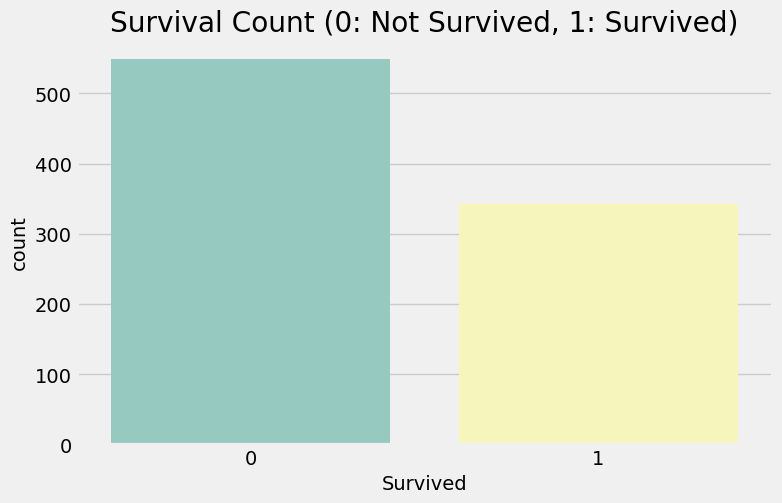

In [18]:
#Countplot of survivors

plt.figure(figsize=(8, 5))
sns.countplot(data=train, x='Survived', palette="Set3")
plt.title("Survival Count (0: Not Survived, 1: Survived)")
plt.show()

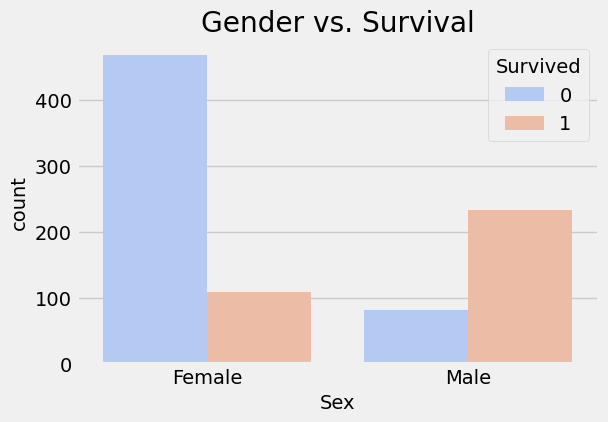

In [19]:
#  Gender vs. Survival

plt.figure(figsize=(6, 4))
sns.countplot(data=train, x='Sex', hue='Survived', palette="coolwarm")
plt.title("Gender vs. Survival")
plt.xticks([0, 1], ['Female', 'Male'])
plt.show()

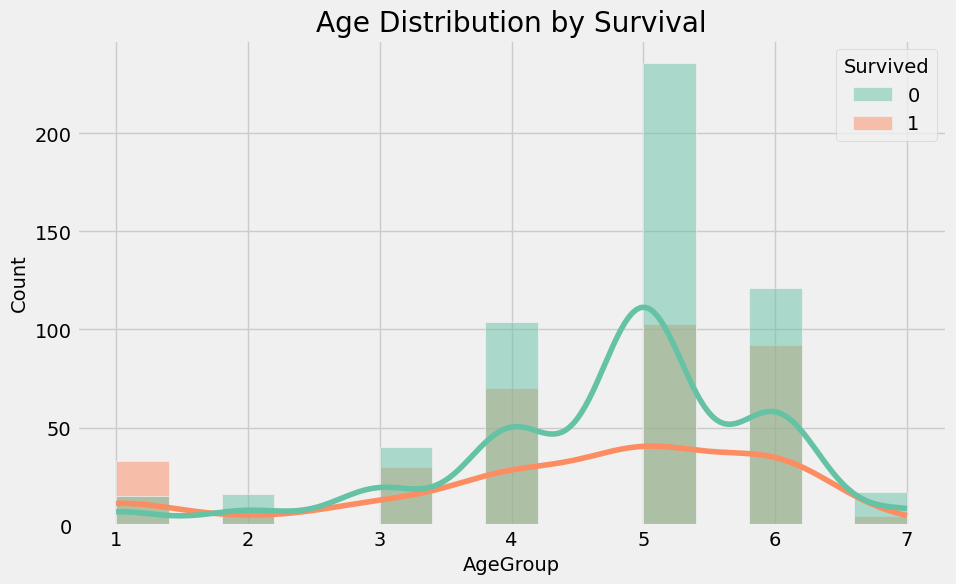

In [20]:
# Age distribution by survival
plt.figure(figsize=(10, 6))
sns.histplot(data=train, x='AgeGroup', hue='Survived', palette="Set2", kde=True)
plt.title("Age Distribution by Survival")
plt.show()

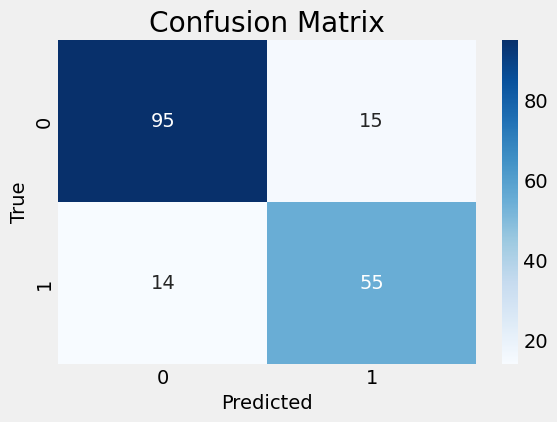

In [21]:
# Confusion Matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix")
plt.show()